<a href="https://colab.research.google.com/github/dtabuena/EphysLib/blob/main/Graph_a_Trace.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
'Get Standard Modules'

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy import stats
import os
from scipy.signal import butter,filtfilt
from tqdm import tqdm
import warnings
from IPython.display import clear_output
from datetime import datetime
import sys
import warnings
import shutil
from google.colab import files
warnings.filterwarnings('ignore')
np.set_printoptions(threshold=sys.maxsize)
clear_output(wait=False)



!pip install openpyxl
!pip install XlsxWriter


'''Get Repositories'''
try: shutil.rmtree('/content/EphysLib')
except: None

"run dtabuena's ephys notebooks"
!git clone https://github.com/dtabuena/EphysLib
to_import = [
            'ABF_Quality_Control.ipynb',
            'Basic_Ephys.ipynb',
            'Simple_ABF_tools.ipynb',
            'fun_math.ipynb',
            'importing_abfs_from_dropbox.ipynb',
            'QC_recoding_dataframe.ipynb',
            'Analyzers/input_resistance_analyzer.ipynb',
            'Analyzers/gain_analyzer.ipynb',
            'Analyzers/latencey_analyzer.ipynb',
            'Analyzers/IV_analyzer.ipynb',
            'Analyzers/Vm_analyzer.ipynb',
            'Analyzers/membrane_analyzer.ipynb',
            'Analyzers/rheobase_analyzer.ipynb',
            'Ephys_wrapper.ipynb',
            ]
for i in to_import:
    f = '/content/EphysLib/' + i
    %run $f

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.7/152.7 kB 7.5 MB/s eta 0:00:00
Cloning into 'EphysLib'...
remote: Enumerating objects: 1008, done.
remote: Counting objects: 100% (385/385), done.
remote: Compressing objects: 100% (192/192), done.
remote: Total 1008 (delta 294), reused 230 (delta 193), pack-reused 623
Receiving objects: 100% (1008/1008), 14.34 MiB | 13.54 MiB/s, done.
Resolving deltas: 100% (671/671), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.2/53.2 kB 4.3 MB/s eta 0:00:00


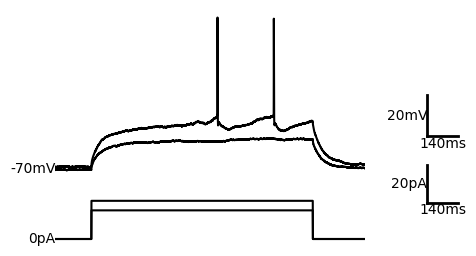

In [14]:
def sample_sweep_publish(abf,plot_ratio = (4,1) ,xlim=[],ylim=[],slim=np.inf,use_ch2 = True,rel_xy_bar=[0.1, 0.1],base=[-70,0] ):
    fig,ax = plt.subplots(2,figsize=(4,3),height_ratios=plot_ratio)
    for s in abf.sweepList:
        if s<slim:
            abf.setSweep(s,0)
            ax[0].plot(abf.sweepX*1000,abf.sweepY,'k')
            if use_ch2:
                abf.setSweep(s,1)
                ax[1].plot(abf.sweepX*1000,abf.sweepY,'k')
            else:
                abf.setSweep(s,0)
                ax[1].plot(abf.sweepX*1000,abf.sweepC,'k')
            # print(abf.adcUnits)
    if len(xlim) == 2:
        ax[0].set_xlim(xlim)
        ax[1].set_xlim(xlim)

    

    for i in range(len(ax)):
        axi = ax[i]
        axi.axis('off')
        xlim = axi.get_xlim()
        x_range = np.diff(xlim)
        x_bar_len = x_range*rel_xy_bar[0]
        x_bar_len = x_bar_len.astype("int")
        x_0 = xlim[1]+x_bar_len*2

        ylim = axi.get_ylim()
        y_range = np.diff(ylim)
        y_bar_len = y_range*rel_xy_bar[1]
        y_bar_len = y_bar_len*( np.sum(plot_ratio) / plot_ratio[i] )

        y_bar_len=5*np.ceil(y_bar_len/5).astype("int")

        y_0 = ylim[0]+y_bar_len


        x,y = np.array([[x_0, x_0+x_bar_len], [y_0, y_0]])
        x_line = plt.Line2D(x, y, lw=2, color='k', alpha=1)
        x_line.set_clip_on(False)

        axi.add_line(x_line)


        x,y = np.array([[x_0, x_0], [y_0, y_0+y_bar_len]])
        y_line = plt.Line2D(x, y, lw=2, color='k', alpha=1)
        y_line.set_clip_on(False)

        axi.add_line(y_line)



        axi.text(x_0+x_bar_len/2, y_0,  str(x_bar_len[0])+'ms',ha='center',va='top')
        abf.adcUnits
        axi.text(x_0, y_0+y_bar_len/2,  str(y_bar_len[0])+abf.adcUnits[i],ha='right',va='center')

        
        axi.text(xlim[0],base[i],str(base[i]) + abf.adcUnits[i],ha='right',va='center')

    abf.setSweep(0,0)
    return None

abf= abf_or_name('/content/2022x11x30_E4KI_F_P564_s002_c005_DG_0004.abf')
sample_sweep_publish(abf,xlim=[400,1800],slim=3,use_ch2=False,rel_xy_bar=[0.1, 0.18],base=[-70,0] )



In [ ]:
''' Requires: 
    Simple_ABF_tools.ipynb
    Basic_Ephys.ipynb
'''

def rheobase_analyzer(file_name,
                        spike_args =  {'spike_thresh':20, 'high_dv_thresh': 25,'low_dv_thresh': -50,'window_ms': 2},
                        to_plot=False,
                        verbose=False,
                        single_spike=True,dpi=100):
    
    ''' File Analyzer for Rheobase etc  '''

    results = {} # default return

    abf = abf_or_name(file_name)


    # Rheobase Measure:
    if len(abf.sweepList)<2:
        return results
    else:
        is_base, is_stim = protocol_baseline_and_stim(abf)
        stim_currents, spike_counts, spike_rates, V_before_AP,V_before_stim,_ ,_= spikes_per_stim_LEGACY(abf, spike_args,to_plot=to_plot)
        single_spikes = spike_counts==1
        zero_spikes = spike_counts==0
        if single_spike:
            none_to_one = np.full(single_spikes.shape, False)
            none_to_one[1:] = np.logical_and(single_spikes[1:], zero_spikes[:-1])
            first_spike_stim = np.where(none_to_one)[0]
        else:
            some_spikes = spike_counts>0
            none_to_some = np.full(single_spikes.shape, False)
            none_to_some[1:] = np.logical_and(some_spikes[1:], zero_spikes[:-1])
            first_spike_stim = np.where(none_to_some)[0]


    if first_spike_stim.size == 0:
        return results
    else:
        if first_spike_stim.size >1:
            first_spike_stim = np.min(first_spike_stim)
        results['Rheobase'] = stim_currents[first_spike_stim][0]
        results['Vhold_spike'] = V_before_stim[first_spike_stim][0]
        results['AP_thresh'] = V_before_AP[first_spike_stim][0]

    if first_spike_stim.size>0:
        # try:
        abf = abf_or_name(file_name)
        abf.setSweep(first_spike_stim[0])
        ap_params = single_ap_stats(abf,spike_args,window_ms=[-3, 9.5],to_plot=to_plot,verbose=verbose)
        results.update(ap_params)
        # except:
        #     print('ap_stats_failed: ', file_name)


    if to_plot:
        rheo_fig, ax = plt.subplots(1,1)
    
        try:    os.makedirs('Saved_Figs/Rheobase/')
        except:     None
        for s in abf.sweepList:
            abf.setSweep(s)
            ax.plot(abf.sweepX,abf.sweepY,label = str(stim_currents[s]) + ' pA')      
        ax.legend(loc='center left') #,bbox_to_anchor=(1,0.5)
        plt.show()
        plt.tight_layout()
        rheo_fig.savefig( 'Saved_Figs/Rheobase/Rheobase' + '_' + abf.abfID +'.png',dpi=dpi)
        

    return results


[0, 1]
ap_thresh_us -42.27131907728884


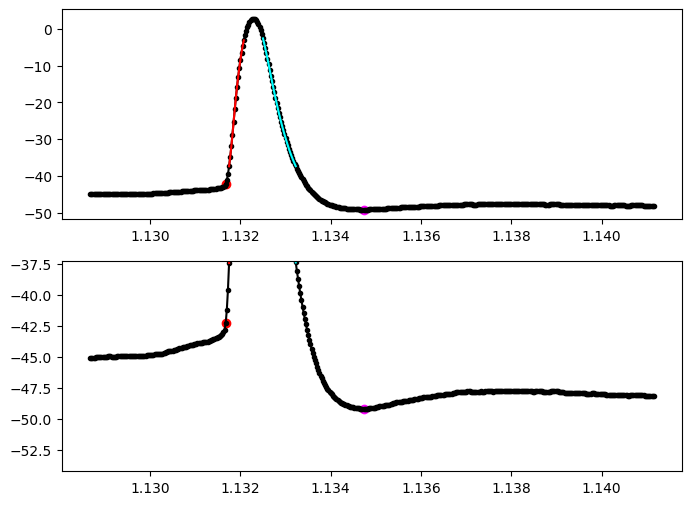

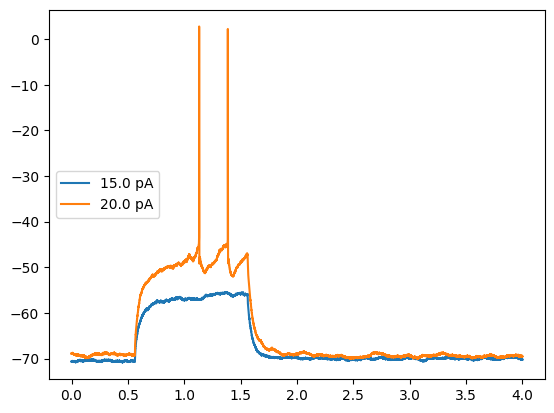

<Figure size 640x480 with 0 Axes>

In [18]:
abf= abf_or_name('/content/2022x11x30_E4KI_F_P564_s002_c005_DG_0004.abf')
print(abf.sweepList)
x = rheobase_analyzer(abf, spike_args =  {'spike_thresh':20, 'high_dv_thresh': 25,'low_dv_thresh': -50,'window_ms': 2},to_plot=True,verbose=False, single_spike=False,dpi=100)
print()